In [14]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130
!pip install pandas scikit-learn numpy
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu130, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Imports

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Dataset pull from training, test, and val csvs

In [16]:
# Fetch the records and put them in a DataFrame
base_path = "D:/DDriveFiles/School files/College Stuff/Machine Vision/Project/"
record_set_df = pd.read_csv(base_path + 'labels_train.csv')
record_set_df.head()
record_set_df2 = pd.read_csv(base_path + 'labels_trainval.csv')
record_set_df.head()
record_set_df3 = pd.read_csv(base_path + 'labels_val.csv')
record_set_df.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


Remove the headers, merge the csvs back into a single dataset

In [17]:
def remove_headers(df):
    df.columns = [col.split('/')[-1] for col in df.columns]
    return df
record_set_df = remove_headers(record_set_df)
record_set_df2 = remove_headers(record_set_df2)
record_set_df3 = remove_headers(record_set_df3)

dataset = pd.concat([record_set_df, record_set_df2, record_set_df3], ignore_index=True)
print(dataset)

                          frame  xmin  xmax  ymin  ymax  class_id
0       1478019952686311006.jpg   237   251   143   155         1
1       1478019952686311006.jpg   437   454   120   186         3
2       1478019953180167674.jpg   218   231   146   158         1
3       1478019953689774621.jpg   171   182   141   154         2
4       1478019953689774621.jpg   179   191   144   155         1
...                         ...   ...   ...   ...   ...       ...
330205  1479498536475329921.jpg   337   350   136   150         1
330206  1479498536475329921.jpg   360   441   117   147         2
330207  1479498536475329921.jpg   365   385   136   147         1
330208  1479498536475329921.jpg   398   432   134   144         1
330209  1479498536475329921.jpg   453   479   128   160         1

[330210 rows x 6 columns]


In [18]:
class_counts = dataset['class_id'].value_counts().sort_index()
print(class_counts)

class_id
1    246628
2     14644
3     31080
4      3352
5     34506
Name: count, dtype: int64


Show a testing image

[1 3 2 5 4]


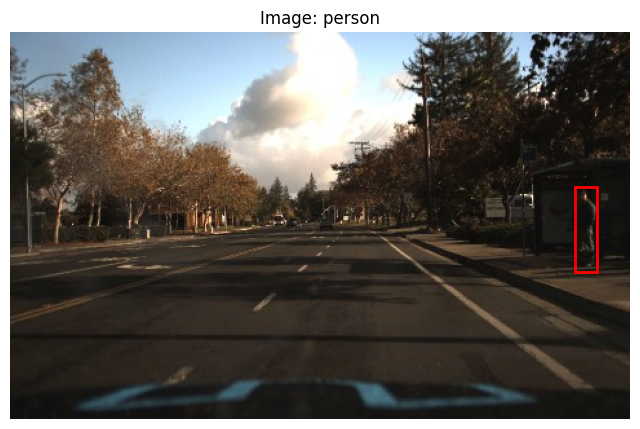

Pixel max Value: 1.0
Pixel min Value: 0.0


In [19]:
classes = dataset.class_id.unique()
print(classes)
labels = { 1:'car', 2:'truck', 3:'person', 4:'bicycle', 5:'traffic light'}

boxes = {}
images ={}
ind =1
img_path = base_path + 'images/'

images[0] = cv2.imread(img_path + dataset['frame'][ind])
images[0] = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
images[0] = images[0].astype('float32')/255.0
boxes[0] = [dataset['xmin'][ind],dataset['xmax'][ind],dataset['ymin'][ind],dataset['ymax'][ind]]
plt.figure(figsize=(8,10))
plt.title("Image: " + str(labels[dataset['class_id'][ind]]))
plt.imshow(images[0])

xmin, xmax, ymin, ymax = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='red', fill=False, linewidth=2))
plt.axis('off')
plt.show()

print("Pixel max Value: " + str(np.max(images[0])))
print("Pixel min Value: " + str(np.min(images[0])))

Build Dataset

[[[120 136 161]
  [114 130 155]
  [108 125 151]
  ...
  [ 19  18  14]
  [ 37  36  32]
  [ 51  52  46]]

 [[121 138 164]
  [118 135 161]
  [115 132 158]
  ...
  [ 22  18  15]
  [ 25  24  19]
  [ 21  22  16]]

 [[117 137 164]
  [117 137 164]
  [117 137 164]
  ...
  [ 26  22  19]
  [ 23  22  17]
  [ 16  15  10]]

 ...

 [[ 15  15  15]
  [ 15  15  15]
  [ 16  16  16]
  ...
  [ 19  18  16]
  [ 19  18  16]
  [ 20  19  17]]

 [[ 15  15  15]
  [ 15  15  15]
  [ 15  15  15]
  ...
  [ 19  18  16]
  [ 19  18  16]
  [ 20  19  17]]

 [[ 15  15  15]
  [ 15  15  15]
  [ 15  15  15]
  ...
  [ 19  18  16]
  [ 19  18  16]
  [ 20  19  17]]]


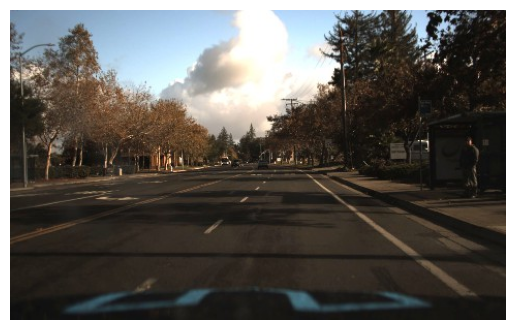

In [20]:
images ={}

img =cv2.imread(img_path + dataset['frame'][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img)
#img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

Dataset building and Train-Test Split

In [21]:

class ImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        img_name = self.data.iloc[index]['frame']
        img_path = os.path.join(self.img_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label = self.data.iloc[index]['class_id']
        return image, label
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

#train, test, val split, with 70% training, 15% val, 15% test
training_set, testing_set = train_test_split(dataset, test_size=0.3, random_state=42)
validation_set, testing_set = train_test_split(testing_set, test_size=0.5, random_state=42)

#convert dataset to include just images and their labels
train_set = ImageDataset(training_set, img_dir=img_path, transform=transform)
val_set = ImageDataset(validation_set, img_dir=img_path, transform=transform)
test_set = ImageDataset(testing_set, img_dir=img_path, transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [22]:
for images, labels in train_loader:
    print(images.shape)
    break

torch.Size([32, 3, 224, 224])


CNN Model Definition

In [23]:
print(torch.cuda.is_available())

True


In [24]:
#Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.num_no_improve =0
    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.num_no_improve =0
            return False
        else:
            self.num_no_improve+=1
            if self.num_no_improve >= self.patience:
                return True
            return False

early_stopper = EarlyStopping(patience = 5, delta = 0.001)

In [25]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.full = nn.Linear(32*28*28, num_classes)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxPool(x)
        x = F.relu(self.conv2(x))
        x = self.maxPool(x)
        x = F.relu(self.conv3(x))
        x = self.maxPool(x)
        x = x.flatten(1)
        x = self.full(x)
        return x

class_counts = training_set['class_id'].value_counts().sort_index().to_numpy()
print(class_counts)
class_counts = torch.tensor(class_counts, dtype=torch.float32)
weights = 1/torch.sqrt(class_counts)
weights = weights / weights.sum() * len(weights)
print(weights)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = weights.to(device)
model = CNN(3, 5).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer= torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

[172673  10270  21799   2345  24060]
tensor([0.2608, 1.0692, 0.7339, 2.2376, 0.6986])


Training

In [26]:
num_epochs =100
for epochs in range(num_epochs):
    total_train_loss =0
    total_val_loss =0
    count =0
    model.train()
    for images, labels in train_loader:
        x, y = images.to(device), (labels-1).to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        count +=1
        ten_perc = int(len(train_loader)/10)
        if count % ten_perc == 0:
            print(str((count/ten_perc)*10) + "% done")
    average_train_loss = total_train_loss/len(train_loader)
    val_count =0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            x, y = images.to(device), (labels-1).to(device)
            output = model(x)
            loss = criterion(output, y)
            total_val_loss += loss.item()
            val_count +=1
            ten_val_perc = int(len(val_loader)/10)
            if val_count % ten_val_perc ==0:
                print(str((val_count/ten_val_perc)*10) + "% done")
    average_val_loss = total_val_loss/len(val_loader)
    scheduler.step(average_val_loss)
    print("Epoch {} Average Train Loss: {:.6f} Average Val Loss: {:.6f}".format(epochs+1, average_train_loss, average_val_loss))
    if early_stopper.check_early_stop(average_val_loss):
        print("Stopping at epoch " + str(epochs+1) + " because val loss isn't improving, and early stop function triggered.") 
        break;


10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Epoch 1 Average Train Loss: 1.037742 Average Val Loss: 0.964698
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Epoch 2 Average Train Loss: 0.915074 Average Val Loss: 0.900681
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Epoch 3 Average Train Loss: 0.859184 Average Val Loss: 0.869507
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
10.0% done
20.0% done
30.0% don

In [27]:
#evaluation
model.eval()
total_test_loss =0
all_preds = []
all_labels = []
count =0
with torch.no_grad():
    for images, labels in test_loader:
        x, y = images.to(device), (labels-1).to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        total_test_loss += loss.item()
        all_preds.append(outputs)
        all_labels.append(y)
        count +=1
        one_perc = int(len(test_loader)/100)
        if count % one_perc == 0:
            print(str(count/one_perc) + "% done")

1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0% done
89.0% done
90.0% done
91.0% done
92.0% do

In [28]:
all_preds_flat = []
all_labels_flat = []

for pred, label in zip(all_preds, all_labels):
    pred_labels = pred.argmax(dim=1)
    all_preds_flat.extend(pred_labels.tolist())
    all_labels_flat.extend(label.tolist())
    
average_test_loss = total_test_loss / len(test_loader)
print(f"Average Test Loss: {average_test_loss:.4f}")
accuracy = accuracy_score(all_labels_flat, all_preds_flat)
print(f"Accuracy: {accuracy:.4f}")
classification = classification_report(all_labels_flat, all_preds_flat)
print(f"Classification Report:\n{classification}")

Average Test Loss: 0.8098
Accuracy: 0.6921
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81     37052
           1       0.19      0.25      0.22      2149
           2       0.46      0.55      0.50      4669
           3       0.15      0.67      0.25       474
           4       0.41      0.68      0.52      5188

    accuracy                           0.69     49532
   macro avg       0.42      0.58      0.46     49532
weighted avg       0.77      0.69      0.72     49532

